In [1]:
# Author: Muhammad Hammad Khokhar
# Date: 2023-09-21
# Version: 0.1

# **Analysis of lakes temperature in Berlin-Brandenburg**

# **Table of Contents**

1. [Introduction](#introduction)
2. [Problem Statement](#problem-statement)
    - [What is the problem you are trying to solve?](#what-is-the-problem-you-are-trying-to-solve)
    - [What is the context of the problem?](#what-is-the-context-of-the-problem)
3. [Pipeline](#3-pipeline)
    - [Import Libraries](#import-libraries)
    - [Import Dataset](#load-data)
    - [Columns Explained](#columns-explained)
    - [Dataset Split](#dataset-split)
    - [Data Exploration](#data-exploration)
    - [Data Pre-Processing](#data-preprocessing)
    - [Split Features and Target Label](#split-features-and-target-label)
    - [Feature Engineering](#feature-engineering)
    - [Training and Testing of the Model](#training-and-testing-of-the-model)
    - [Evaluation](#evaluation)
    - [Conclusion](#conclusion)
    - [References](#references)

# **1. Introduction**

> In this end-to-end machine learning pipeline, we will explore the regional water temperatures in Berlin, Brandenburg and the Altmark over time. To understand the temperature changes and gain insight into how the temperature of these lakes may affect the climate, which lake requires more attention for climate sustainability.<br><br> The dataset is sourced from [Wassersport InformationsDienst Berlin](https://wind.met.fu-berlin.de/mvdtext/mvd_text.htm) using crawler by [Jonas](https://github.com/jnsprnw), dataset can be accessed via [Download Dataset](https://github.com/jnsprnw/water-temperatures-berlin/blob/main/data.csv)

# **2. Problem Statement**

##### What is the problem you are trying to solve?

> These regions suffer from water deficits despite numerous lakes (Stock and Lahmer, 2020) By 2055, the water balance affected by some parameters will worsen water and have dramatic consequences, according to an impact study conducted by the Potsdam Institute for Climate Impact Research (PIK) (Stock and Lahmer, 2020).

##### What are the potential impacts of this project?

>Temperature is a primary concern causing the climate to change and will lead to problems in the quality of water and its supply. We will use the dataset to predict the temperature of the lakes in the future and analyse the data to take appropriate measures to reduce potential damage to the natural environment.


# **3. Pipeline**

## Import Libraries

Importing the necessary libraries for the project. 

In [762]:
import pandas as pd # To read csv files
from sklearn.metrics import mean_squared_error, r2_score # To evaluate our model
from sklearn.model_selection import train_test_split # To split our data into training and testing data
import matplotlib.pyplot as plt # To plot our data
import seaborn as sns # To plot our data
import numpy as np # To perform mathematical operations
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor # To perform Gradient Boosting
from sklearn.model_selection import GridSearchCV # To perform Grid Search
from sklearn.tree import DecisionTreeRegressor # To perform Decision Tree Regression

## Import Dataset

Below we import the dataset and list the first 8 rows of the dataset.

In [763]:
# read the dataset
df = pd.read_csv('./datasets/Wassersport_InformationsDienst_Berlin.csv')

# show the shape of the dataset (rows, columns)
rows_and_cols = df.shape 
print(f"Total Rows: {rows_and_cols[0]}", f"Total Columns: {rows_and_cols[1]}", sep='\n')

# Add a line separator
print("-" * 50)

# Show the first 8 rows of the dataset
first_eight_rows = df.head(8)
print("First 8 rows:")
first_eight_rows

Total Rows: 4080
Total Columns: 4
--------------------------------------------------
First 8 rows:


,location,temperature,dateTemperature,dateScrape
0,Wannsee,4.3,2022-12-01T08:00:00Z,2022-12-01T14:08:36.931Z
1,Tegeler See,5.9,2022-12-01T08:00:00Z,2022-12-01T14:08:36.931Z
2,Müggelsee,4.3,2022-12-01T08:00:00Z,2022-12-01T14:08:36.931Z
3,Stechlinsee,7.5,2022-12-01T08:00:00Z,2022-12-01T14:08:36.931Z
4,Havel/Spandau,4.5,2022-12-01T08:00:00Z,2022-12-01T14:08:36.931Z
5,Oder/Kienitz,3.9,2022-12-01T08:00:00Z,2022-12-01T14:08:36.931Z
6,Scharfe Lanke / Pichelsdorf,5.4,2022-12-01T08:00:00Z,2022-12-01T14:08:36.931Z
7,Arendsee,NaN,2022-12-01T08:00:00Z,2022-12-01T14:08:36.931Z


## Columns Explained

Definition of the columns of the dataset and their data types.

| Column Name       | Definition                | Data Type        |
|:------------------|:--------------------------|:-----------------|
| **location**      | Location of the lake      | String           |
| **temperature**   | Temperature of the lake   | Float            |
| **dateTemperature** | Date and time of temperature | ISO 8601 string |
| **dateScrape**    | Date and time data scraped | ISO 8601 string |

## Dataset Split

In this section, we split the dataset into two sets, one for training and the other for the testing.

In [764]:
# Split the dataset (75% training, 25% testing)
df_train, df_test = train_test_split(df, test_size=0.25)

# Show the shape of the training and testing data (rows, columns)
print(f"Training Shape: {df_train.shape}", f"Testing Shape: {df_test.shape}", sep='\n')


Training Shape: (3060, 4)
Testing Shape: (1020, 4)


## Data Exploration

In this section we explore the data and analyse to identify any anomalies in the data. 

In [765]:
# Get the locations of the lakes we are targeting
unique_locations = df_train['location'].unique()
result = '\n'.join(map(str, unique_locations))

# with total count
# unique_locations = df_train['location'].value_counts()
print(result)

Arendsee
Stechlinsee
Wannsee
Havel/Spandau
Tegeler See
Oder/Kienitz
Scharfe Lanke / Pichelsdorf
Müggelsee


In [766]:
# Check for missing values (in %)
df_train.isnull().sum()/df_train.shape[0]

location           0.000000
temperature        0.100654
dateTemperature    0.000000
dateScrape         0.000000
dtype: float64

In [767]:
# Total missing temperature values per location where temperature is missing
df_train[df_train['temperature'].isnull()].groupby('location').size()

location
Arendsee       210
Stechlinsee     48
Tegeler See     50
dtype: int64

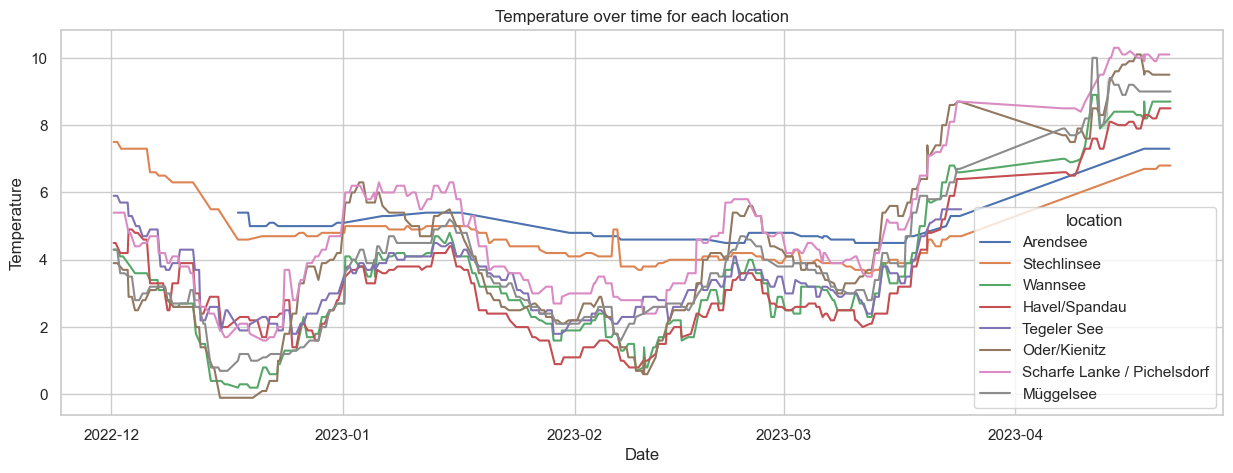

In [768]:
# Temperature over time for each location, to see if there are any outlier and to analyse the trend
df_train['dateTemperature'] = pd.to_datetime(df_train['dateTemperature']) # Convert the dateTemperature column to datetime

# Temperature over time for each location
plt.figure(figsize=(15, 5))
sns.lineplot(x='dateTemperature', y='temperature', hue='location', data=df_train)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature over time for each location')
plt.show()


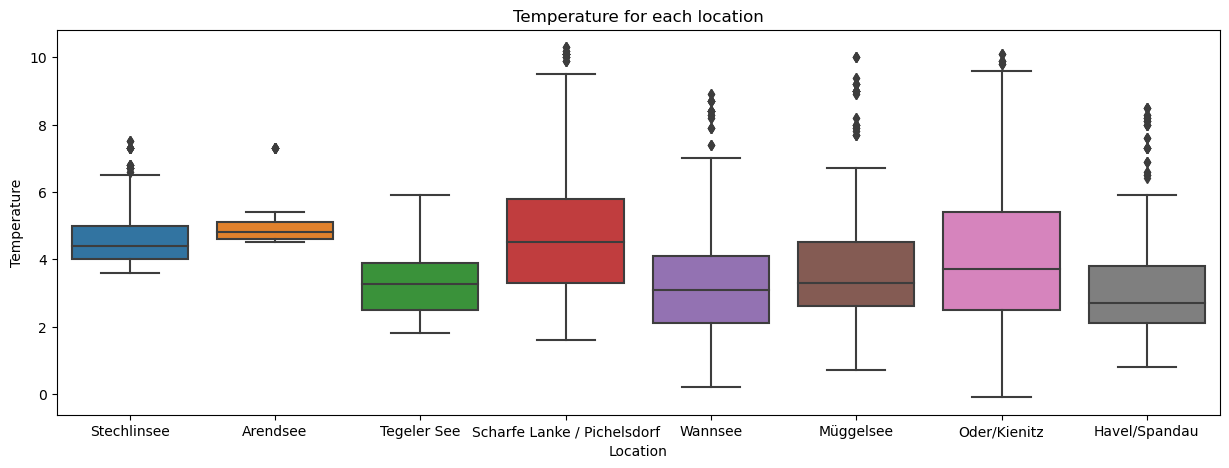

In [330]:
# We could not find outliers in the previous plot, thus we will plot a boxplot for each location to investigate further
plt.figure(figsize=(15, 5))
sns.boxplot(x='location', y='temperature', data=df_train)
plt.xlabel('Location')
plt.ylabel('Temperature')
plt.title('Temperature for each location')
plt.show()

In [769]:
# Check duplicate values by (in %)
df_train.pivot_table(index = ['dateTemperature'], aggfunc ="size")/df_train.shape[0]

dateTemperature
2022-12-01 08:00:00+00:00    0.004575
2022-12-01 14:20:00+00:00    0.002288
2022-12-01 19:30:00+00:00    0.001961
2022-12-02 05:00:00+00:00    0.001961
2022-12-02 08:00:00+00:00    0.001634
                               ...   
2023-04-20 14:30:00+00:00    0.002288
2023-04-20 18:30:00+00:00    0.002288
2023-04-21 08:00:00+00:00    0.004902
2023-04-21 14:30:00+00:00    0.002288
2023-04-21 18:00:00+00:00    0.001634
Length: 493, dtype: float64

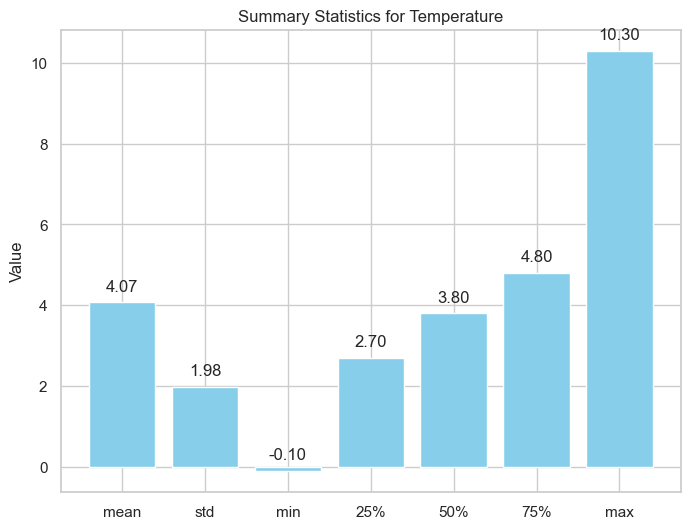

In [770]:
# We will create a bar chart to see the statistical summary of the temperature
temp_stats = df_train["temperature"].describe().drop(["count"])
plt.figure(figsize=(8, 6))
plot = plt.bar(temp_stats.index, temp_stats.values, color='skyblue')
plt.title("Summary Statistics for Temperature")
plt.ylabel("Value")

# Add annotations to each bar
for box, value in zip(plot, temp_stats.values):
    plt.text(box.get_x() + box.get_width() / 2, value + 0.2, f"{value:.2f}", ha='center', va='bottom')

plt.show()

## Data Pre-Processing

In this section, we pre-process the data to make it ready for the machine learning model. Meaning removing/filling null values and data cleaning. We saw previously that some locations has missing temperatures, there are duplicate values and Arendsee is not part of berlin-brandenburg. Also, we will remove the dateScrape column as it is not needed for the model. We also create new columns for the year, month, day, hour and day of the week in order to make our model more accurate.

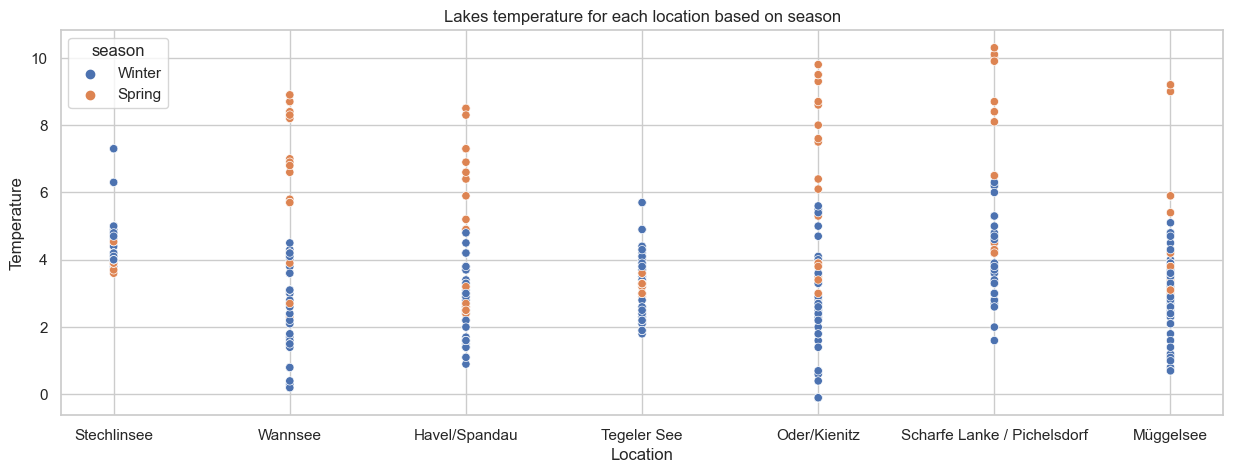

,location,temperature,dateTemperature,dateScrape,dayOfWeek,date,month,year,dayOfYear,quarter,season,avgTemp
1163,Stechlinsee,4.9,2023-01-07 13:45:00+00:00,2023-01-07T17:02:51.354Z,5,2023-01-07,1,2023,7,1,Winter,4.536364
504,Wannsee,0.3,2022-12-18 05:00:00+00:00,2022-12-18T07:02:59.530Z,6,2022-12-18,12,2022,352,4,Winter,3.861111
3564,Havel/Spandau,5.9,2023-03-23 19:00:00+00:00,2023-03-23T23:03:19.885Z,3,2023-03-23,3,2023,82,1,Spring,3.428395
1049,Tegeler See,3.7,2023-01-04 04:30:00+00:00,2023-01-04T07:03:02.448Z,2,2023-01-04,1,2023,4,1,Winter,3.289231
3093,Oder/Kienitz,3.3,2023-03-09 05:00:00+00:00,2023-03-09T07:03:19.926Z,3,2023-03-09,3,2023,68,1,Spring,3.917143


In [786]:
def add_columns_to_avoid_bias(df):
    # Exclude rows with location Arendsee as it is not part of Berlin-Brandenburg
    df = df[df['location'] != 'Arendsee']
    
    # Convert the 'dateTemperature' column to datetime
    df['dateTemperature'] = pd.to_datetime(df['dateTemperature'])

    # Drop duplicate values by 'dateTemperature' column and keep the first value
    df.drop_duplicates(subset=['dateTemperature'], keep='first', inplace=True)

    # fill missing temperature values with the average temperature of the location
    df['temperature'].fillna(df.groupby('location')['temperature'].transform('mean'), inplace=True)

    # Create a new column for the day of the week
    df['dayOfWeek'] = df['dateTemperature'].dt.dayofweek

    # Create a new column for the date
    df['date'] = df['dateTemperature'].dt.date

    # Create a new column for the month
    df['month'] = df['dateTemperature'].dt.month

    # Create a new column for the year
    df['year'] = df['dateTemperature'].dt.year

    # Create a new column for the day of the year
    df['dayOfYear'] = df['dateTemperature'].dt.dayofyear

    # Create a new column for the quarter
    df['quarter'] = df['dateTemperature'].dt.quarter

    # Create a new column for the season
    df['season'] = df['dateTemperature'].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})

    # Create average temperature for each location
    df['avgTemp'] = df.groupby('location')['temperature'].transform('mean')
    return df

# Preprocess the training and testing datasets
df_train = add_columns_to_avoid_bias(df_train)
df_test = add_columns_to_avoid_bias(df_test)

# Plot locations with season and temperature
plt.figure(figsize=(15, 5))
sns.scatterplot(x='location', y='temperature', hue='season', data=df_train)
plt.xlabel('Location')
plt.ylabel('Temperature')
plt.title('Lakes temperature for each location based on season')
plt.show()

df_train.head()

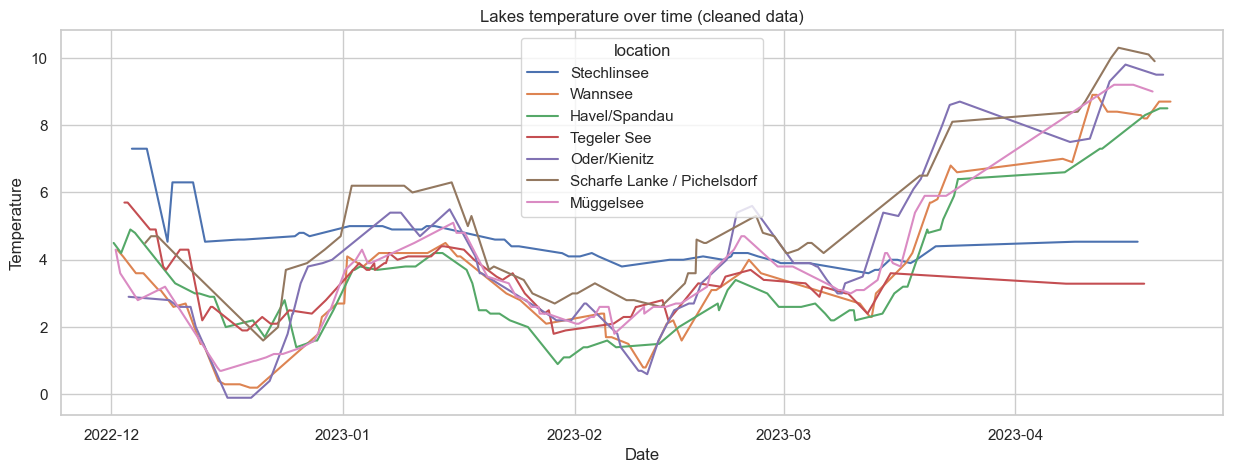

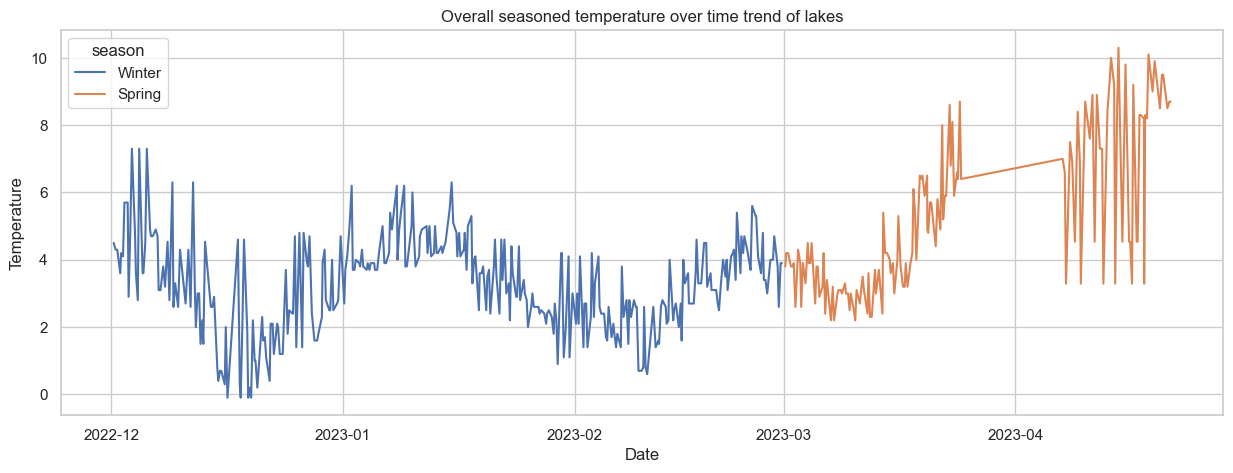

In [774]:
# Temperature over time for each location after cleaning the data
plt.figure(figsize=(15, 5))
sns.lineplot(x='dateTemperature', y='temperature', hue='location', data=df_train)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Lakes temperature over time (cleaned data)')

# seasoned temperature over time for each location
plt.figure(figsize=(15, 5))
sns.lineplot(x='dateTemperature', y='temperature', hue='season', data=df_train)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Overall seasoned temperature over time trend of lakes')
plt.show()

## Split Features and Target Label

In [775]:
# Define the features (X) and target variable (y)
x_train = df_train.drop(["dateScrape", "temperature"], axis=1)
y_train = df_train['temperature']

x_test = df_test.drop(["dateScrape", "temperature"], axis=1)
y_test = df_test['temperature']

## Feature Engineering

In [776]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(x_train)
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (493, 784)
x_test shape:  (433, 784)


## Training and Testing of the Model

In this section, we will train various machine learning models and evaluate their performance. We will use the following models:

- Decision Tree
- Random Forest
- Gradient Boosting

Best hyperparameters for DecisionTreeRegressor: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.3, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 300, 'random_state': 42}
Best hyperparameters for RandomForestRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42}


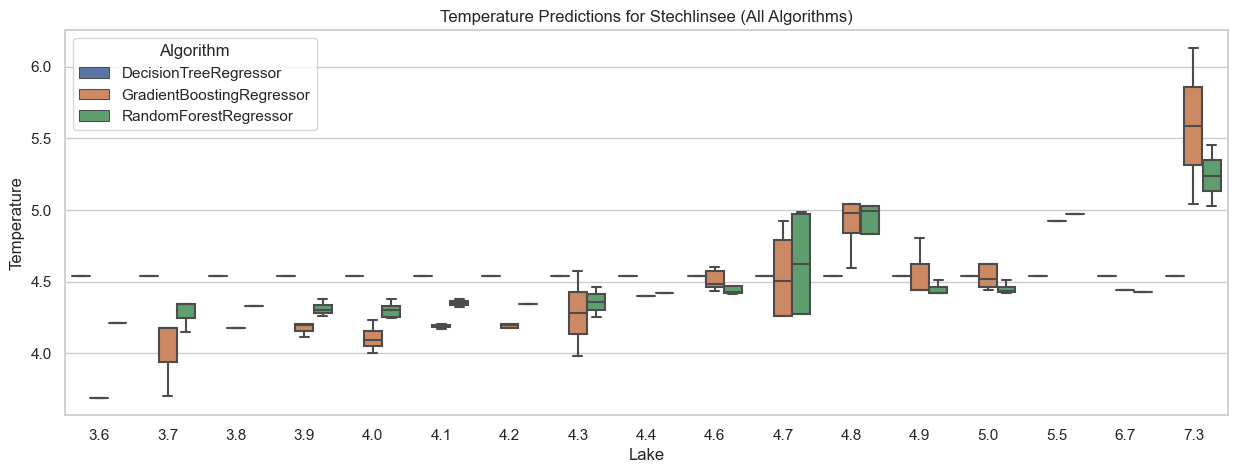

Best hyperparameters for DecisionTreeRegressor: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 42}
Best hyperparameters for RandomForestRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 400, 'random_state': 42}


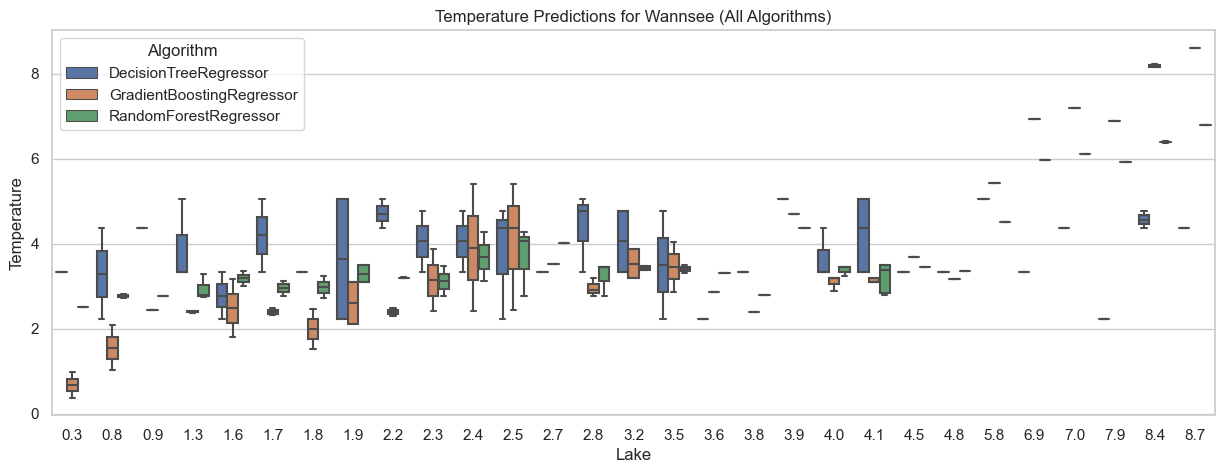

Best hyperparameters for DecisionTreeRegressor: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 42}
Best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.3, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 42}
Best hyperparameters for RandomForestRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42}


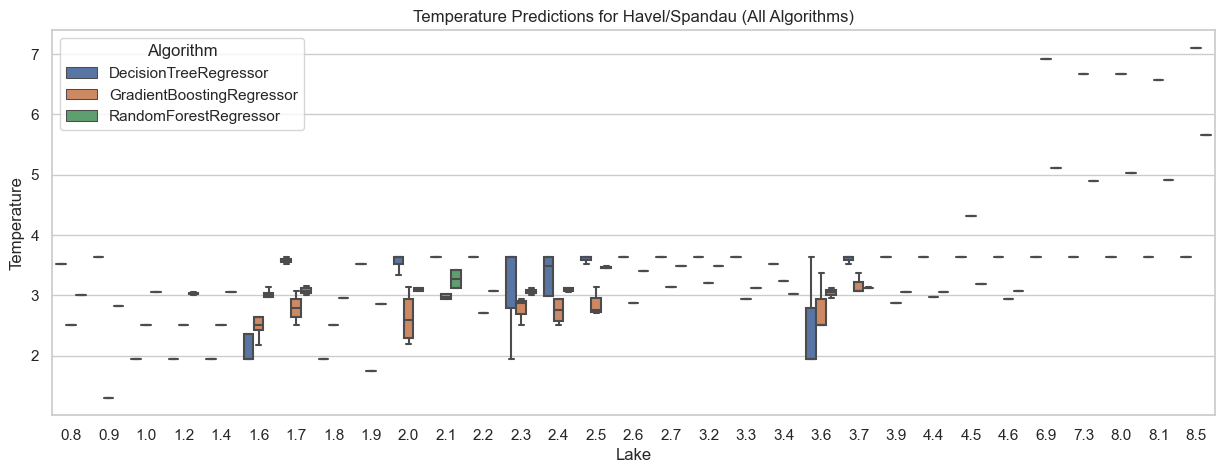

Best hyperparameters for DecisionTreeRegressor: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 42}
Best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200, 'random_state': 42}
Best hyperparameters for RandomForestRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 400, 'random_state': 42}


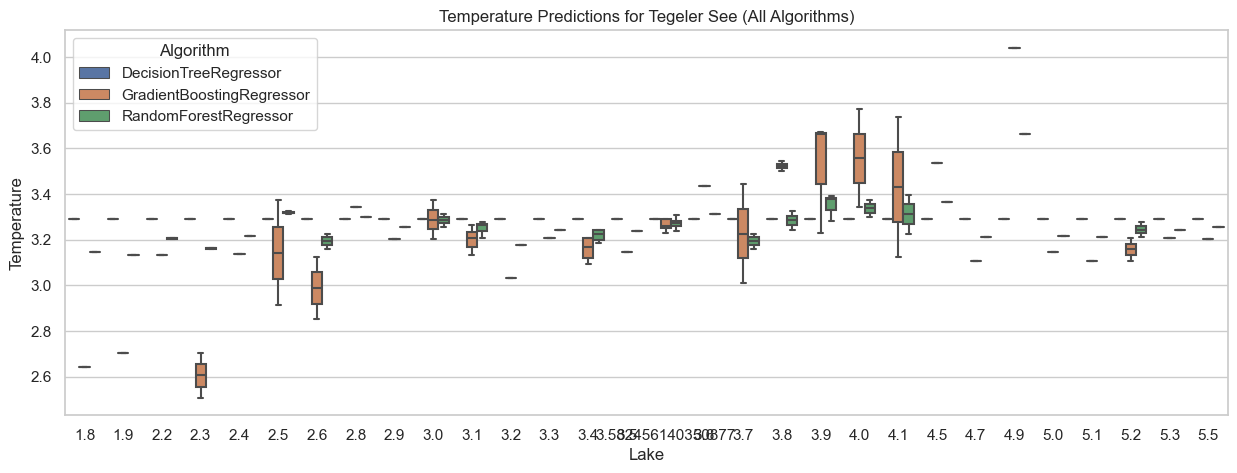

Best hyperparameters for DecisionTreeRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.3, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}
Best hyperparameters for RandomForestRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 42}


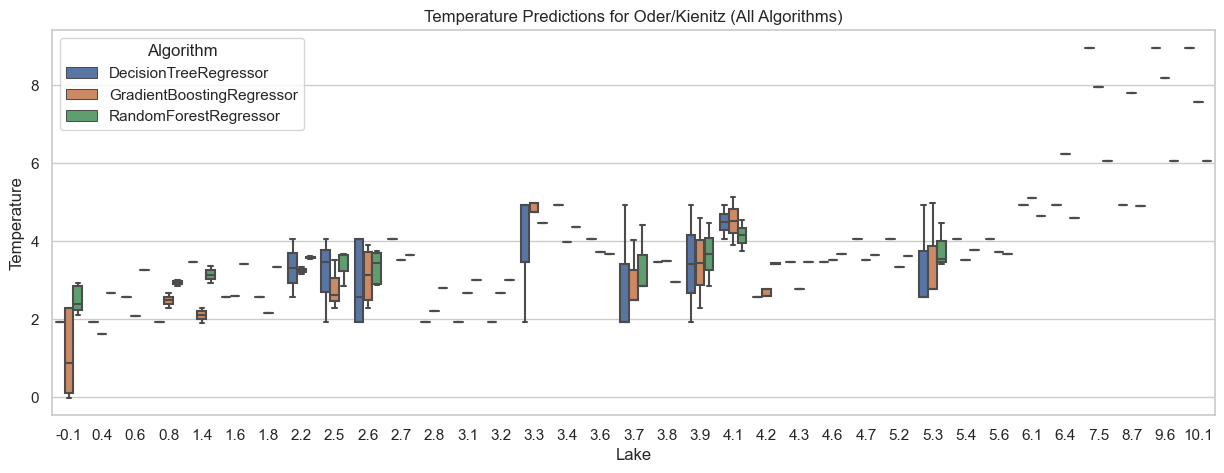

Best hyperparameters for DecisionTreeRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.3, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}
Best hyperparameters for RandomForestRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}


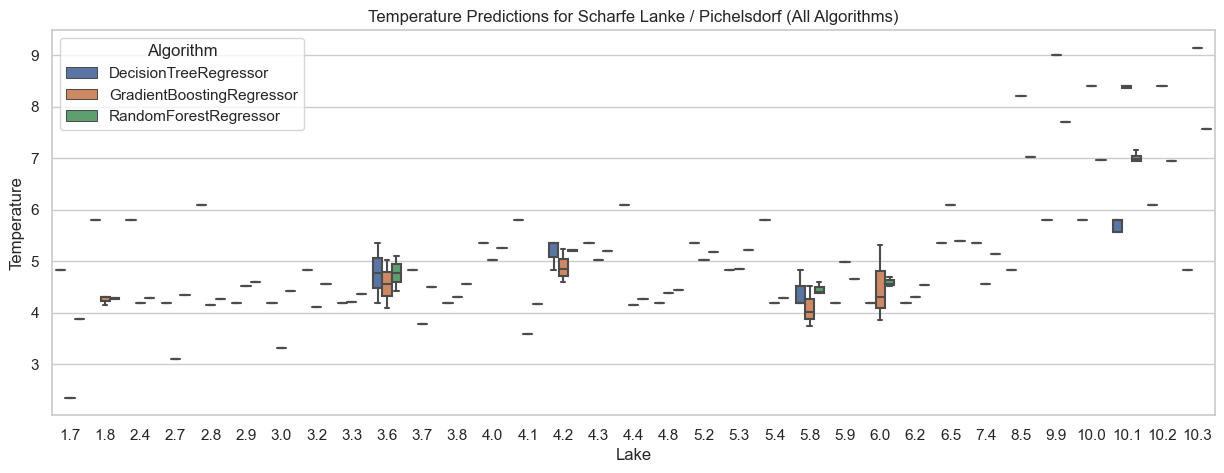

Best hyperparameters for DecisionTreeRegressor: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Best hyperparameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 300, 'random_state': 42}
Best hyperparameters for RandomForestRegressor: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 400, 'random_state': 42}


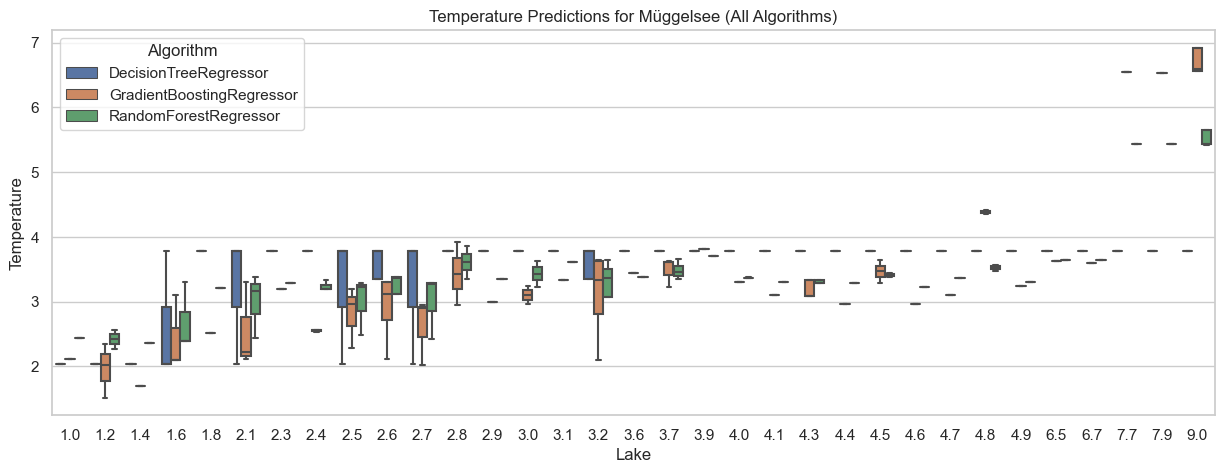

In [795]:
# get the unique locations to run through all models
locations = df_train["location"].unique()

# store the scores for each location in a list to further evaluate the best model
evaluations = []

# loop through each location
for location in locations:
    # matches the location in the training and testing data
    x_location_data = x_train[df_train['location'] == location]
    y_location_data = y_train[df_train['location'] == location]
    x_location_data_test = x_test[df_test['location'] == location]
    y_location_data_test = y_test[df_test['location'] == location]

    # assign training sets
    X = x_location_data
    y = y_location_data

    # Hyperparameters tunings for each model
    hyperparameters = {
        "DecisionTreeRegressor":{
            "max_depth": [2, 3, 4, 5],
            "min_samples_leaf": [2, 3, 4, 5],
            "min_samples_split": [2, 3, 4, 5],
            "max_features": ["sqrt", "log2"],
            "random_state": [42]
        },
        "RandomForestRegressor":{
            "n_estimators": [100, 200, 300, 400, 500],
            "max_depth": [2, 3, 4, 5],
            "max_features": ["sqrt", "log2"],
            "random_state": [42]
        },
        "GradientBoostingRegressor":{
            "learning_rate": [0.1, 0.2, 0.3],
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 4, 5],
            "max_features": ["sqrt", "log2"],
            "random_state": [42]
        }
    }

    # Models to be used
    models = [
        DecisionTreeRegressor(),
        GradientBoostingRegressor(),
        RandomForestRegressor(),
    ]

    # Hypertuning array storage
    finest_models = []

    # Create a dataframe to store the predictions for each location
    predictions_df = pd.DataFrame({'Actual': y_location_data_test})

    # Iterate through models and perform hyperparameter tuning for each one
    for model in models:
        # Get the name of the model
        hyperparameter_name = model.__class__.__name__
        # Get the hyperparameters for the model
        hypertuningParameters = hyperparameters.get(hyperparameter_name, {})
        # Check if the model has hyperparameters
        if hypertuningParameters:
            # Grid search will be used to find the best hyperparameters for each model and we will use 5-fold cross-validation
            grid_search = GridSearchCV(model, hypertuningParameters, cv=5, n_jobs=-1)
            grid_search.fit(X, y)  # Replace X and y with your training data
            best_model = grid_search.best_estimator_  # Get the best model
            finest_models.append(best_model)  # Append the best model to the finest_models list
            print(f"Best hyperparameters for {hyperparameter_name}: {grid_search.best_params_}")
        else:
            finest_models.append(model)

    # store the scores for each model in a list to further evaluate the best model
    scores = []

    # Iterate through each model and train it
    for model in finest_models:
        model.fit(X, y)
        pred = model.predict(x_location_data_test)
        # append the score for each model
        scores.append(model.score(x_location_data_test, y_location_data_test))
        predictions_df[model.__class__.__name__] = pred
    
    # Plot for prediction of lake temperature
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=predictions_df.melt(id_vars='Actual'), x='Actual', y='value', hue='variable', showfliers=False)
    plt.xlabel('Lake')
    plt.ylabel('Temperature')
    plt.title(f'Temperature Predictions for {location} (All Algorithms)')
    plt.legend(title='Algorithm', loc='upper left')
    plt.show()

    # get the index of the best score
    best_score_index = np.argmax(scores)
    best_score = scores[best_score_index]
    best_model = finest_models[best_score_index]
    preds = best_model.predict(x_location_data_test)
    mse = mean_squared_error(y_location_data_test, preds)
    r2 = r2_score(y_location_data_test, preds)
    evaluations.append([location, best_model.__class__.__name__, best_score, mse, r2])
    evaluations_df = pd.DataFrame(evaluations, columns=['location', 'model', 'score', 'mse', 'r2'])

## Evaluations

In this section, we evaluate the model using the mean absolute error, mean squared error and root mean squared error.

<div style="text-align: center"><h4>Mean Squared Error</h4></div>
    
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

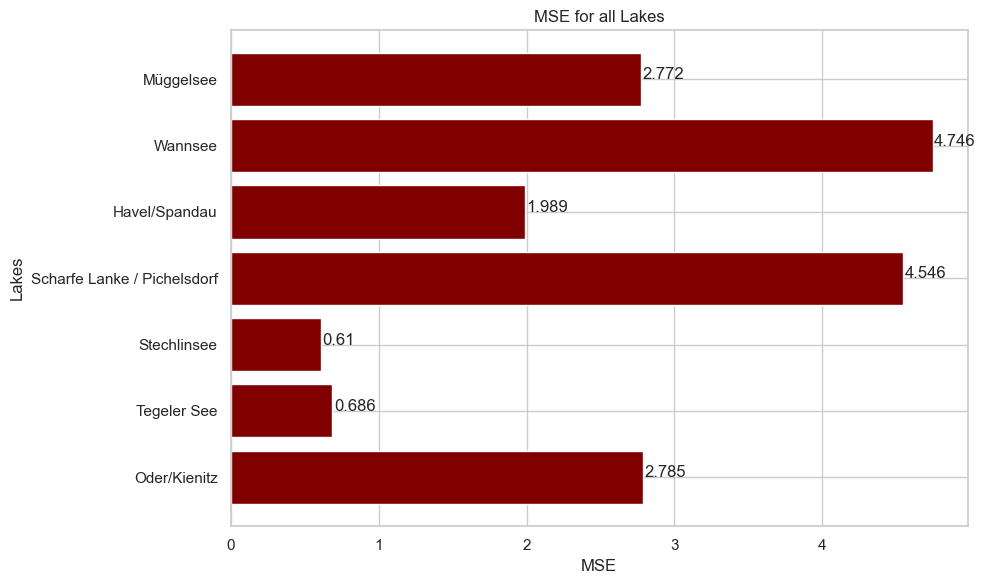

In [752]:
# MSE for each location
plt.figure(figsize=(10, 6))

# create vertical bar chart based on MSE
plt.barh(evaluations_df['location'], evaluations_df['mse'], color='maroon')
plt.xlabel('MSE')
plt.ylabel('Lakes')
plt.title('MSE for all Lakes')

# annotate the bar chart
for i, v in enumerate(evaluations_df['mse']):
    plt.text(v + 0.01, i, str(round(v, 3)))

plt.tight_layout()
plt.show()

<div style="text-align: center"><h4>Coefficient of determination</h4></div>


\begin{align*}
R^2 &= 1 - \frac{SSR}{SST} \\
&= 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
\end{align*}

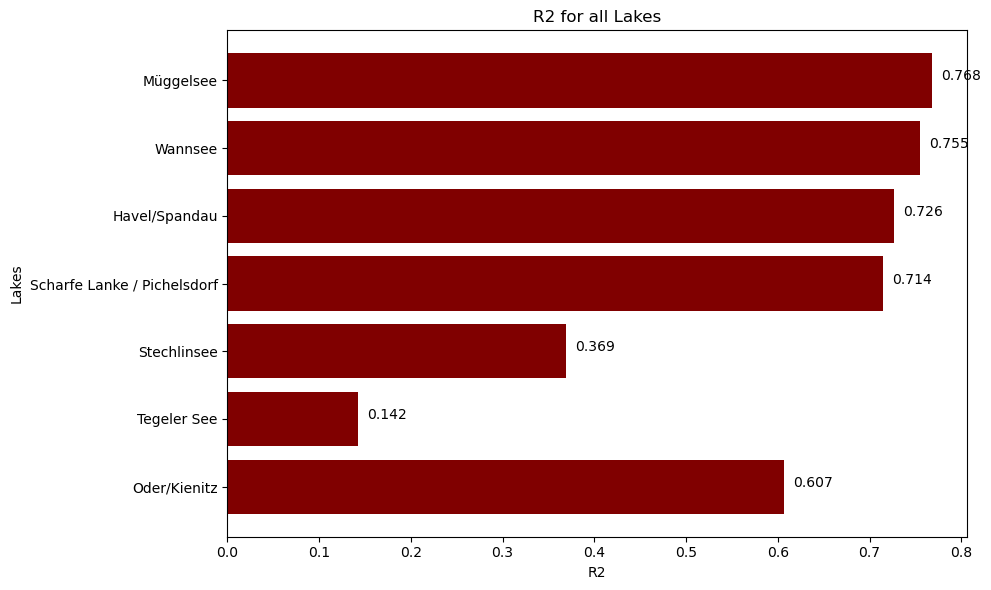

In [722]:
# R2 for each location
plt.figure(figsize=(10, 6))

# create vertical bar chart based on R2
plt.barh(evaluations_df['location'], evaluations_df['r2'], color='maroon')
plt.xlabel('R2')
plt.ylabel('Lakes')
plt.title('R2 for all Lakes')

# annotate the bar chart
for i, v in enumerate(evaluations_df['r2']):
    plt.text(v + 0.01, i, str(round(v, 3)))

plt.tight_layout()
plt.show()

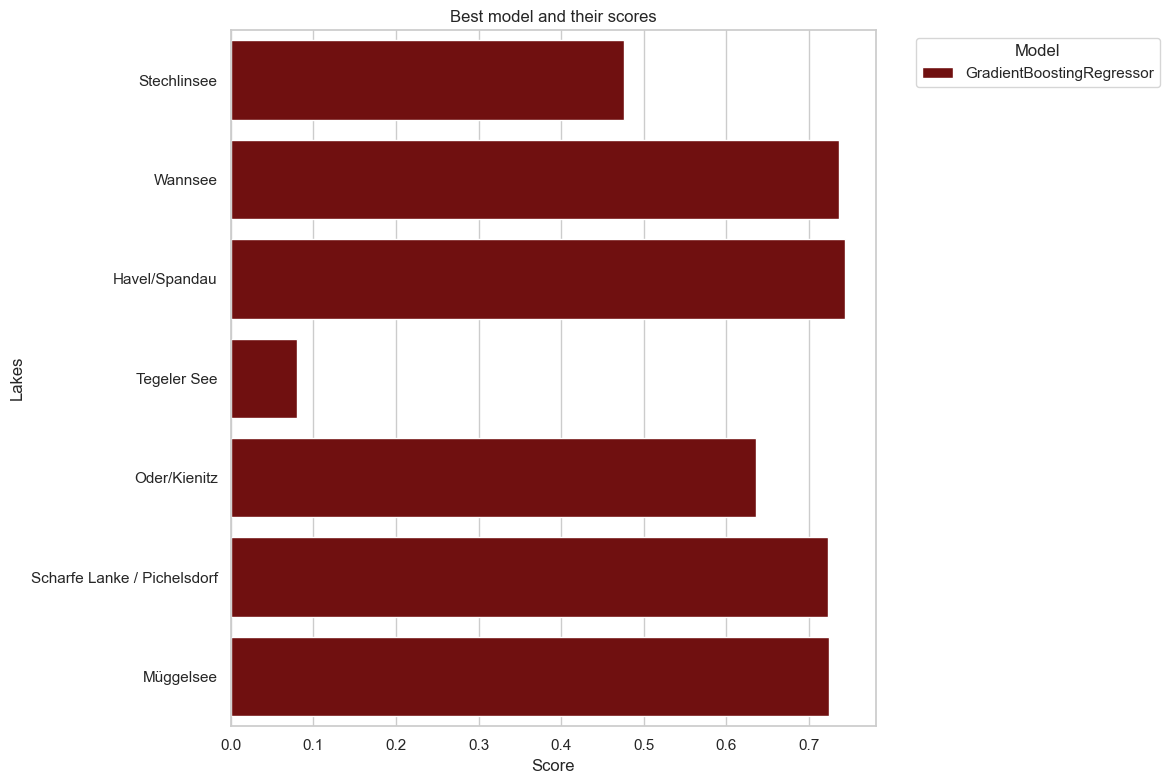

In [804]:
# Comparision of how "Decision Tree Regressor" progressed with the dataset
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x='score', y='location', hue='model', data=evaluations_df, palette=['maroon', 'maroon', 'maroon'])
plt.xlabel('Score')
plt.ylabel('Lakes')
plt.title('Best model and their scores')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Based on the results, Gradient Boosting Regressor model performed the with best results with that we acheived lowest mean squared error and highest coefficient of determination.

Due to lack of data, predicting the future temprature of the lake is not possible at the moment. However, after the deep analysis, it is possible to work on this dataset and include weather details to predict the future temprature of the lake. As the temperature depends on different factors. Thus, with the required support would be interested in working on this project further to predict how the lake temperature will change in the future and produce more insights in order to make the climate sustainable.

I also tried to work with forecasting algorithms but results were not satisfactory.

# References

1. Stock, M. and Lahmer, W. (2020). 3.1.10 Brandenburg: A region in Germany suffering from water deficit -In spite of its numerous lakes. [online] Available at: https://www.klima-warnsignale.uni-hamburg.de/wp-content/uploads/pdf/en/water/global_change-water-chapter-3_1_10.pdf [Accessed 20 Sep. 2023].